# SMC Diagnostics  

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
import pytensor.tensor as pt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-white')

## N-Dimensional Gaussian mixture

First trial for a set with different N of dimensions (20, 40, 60, 80, 100), for a mixture of N-Dimensional Gaussians

In [3]:
dims = [i for i in range(20, 110, 20)]

stdev = 0.1

w1 = 0.1
w2 = (1 - w1)

In [4]:
def two_gaussians(x):
    log_like1 = - 0.5 * n * pt.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    log_like2 = - 0.5 * n * pt.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    return pm.math.logsumexp([pt.log(w1) + log_like1, pt.log(w2) + log_like2])

In [5]:
idatas_gauss = {
    "20": {}, "40": {}, "60": {},
    "80": {}, "100": {},
}

In [6]:
for n in dims:
    mu1 = np.ones(n) * (1. / 2)
    mu2 = -mu1
    sigma = np.power(stdev, 2) * np.eye(n)
    isigma = np.linalg.inv(sigma)
    logdsigma = np.linalg.slogdet(sigma)[1]
    # Model
    with pm.Model() as gaussians:
        X = pm.Uniform('X',
                       shape=n,
                       lower=-2. * np.ones_like(mu1),
                       upper=2. * np.ones_like(mu1),
                       initval=-1. * np.ones_like(mu1))
        llk = pm.Potential('llk', two_gaussians(X))

        idata = pm.sample_smc(5000, chains=4)
        idatas_gauss[str(n)] = idata

Initializing SMC sampler...
Sampling 4 chains in 3 jobs


Initializing SMC sampler...
Sampling 4 chains in 3 jobs


Initializing SMC sampler...
Sampling 4 chains in 3 jobs


Initializing SMC sampler...
Sampling 4 chains in 3 jobs


Initializing SMC sampler...
Sampling 4 chains in 3 jobs


In [7]:
for n in dims:
    idata = idatas_gauss[str(n)]
    print(idata.sample_stats._t_sampling)# Time for each run
    print(az.rhat(idata)["X"].values)
#     print(az.ess(idata)["X"].values)# Not for SMC, for now

110.57150959968567
[1.0000747  1.00021618 1.00004864 1.00002524 1.00008594 0.9999993
 0.99999564 1.00016161 1.00022093 1.00004241 1.00003072 1.000147
 1.00022919 1.00000151 1.00003375 1.00011567 0.99998935 1.00001252
 0.99999519 1.00016446]
201.63497686386108
[1.00027584 1.00044369 1.0003946  1.00021946 1.00025812 1.00020576
 1.00053732 1.0004474  1.00063645 1.00007075 1.00044623 1.00028112
 1.0002862  1.00021219 1.00024868 1.00038197 1.00029488 1.00028562
 1.00044624 1.00034241 1.0002706  1.00029663 1.00034819 1.00011549
 1.00015671 1.0003153  1.00035226 1.00027529 1.0009007  1.00037702
 1.00037459 1.00033851 1.00069079 0.99992743 1.00039182 1.00070768
 1.0004367  1.00022989 1.00028402 1.00026829]
281.1069493293762
[1.00054769 1.00107203 1.00076651 1.00082355 1.00042678 1.00084352
 1.00058319 1.0007101  1.0003298  1.00023221 1.00137176 1.0009494
 1.00026402 1.00102962 1.0002249  1.0007412  1.00026682 1.00083651
 1.00017092 1.00023661 1.0018391  1.0009465  1.00052428 1.00082505
 1.0007

0.09645
0.078
0.050050833333333336
0.030100625
0.0119505


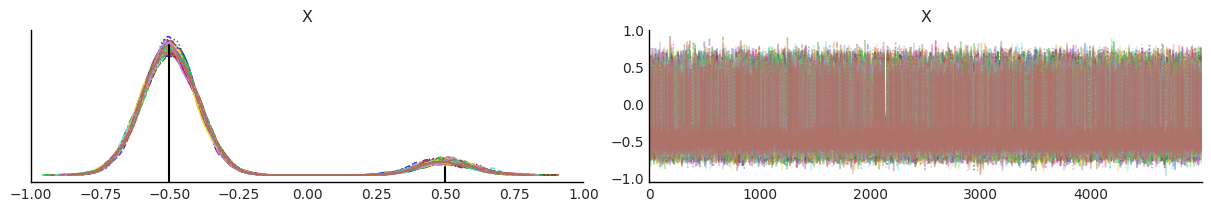

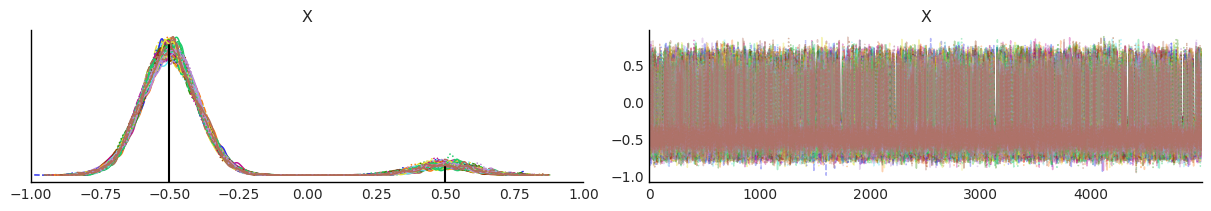

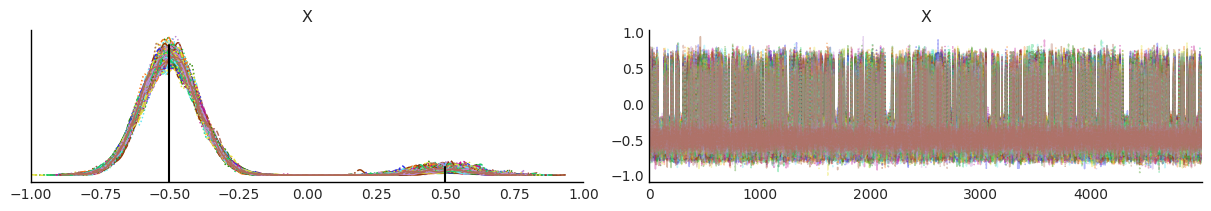

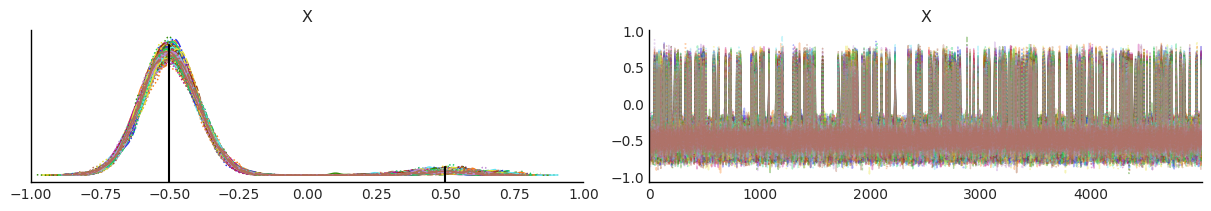

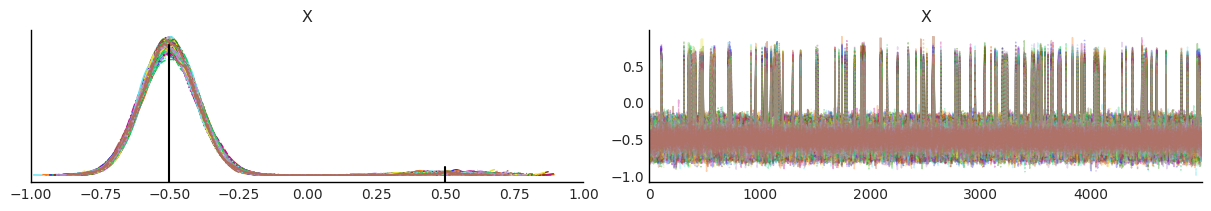

In [8]:
for n in dims:
    idata = idatas_gauss[str(n)]
    ax = az.plot_trace(idata, compact=True)
    ax[0, 0].axvline(-0.5, 0, .9, color="k")
    ax[0, 0].axvline(0.5, 0, 0.1, color="k")
    ax[0, 0].set_xlim(-1, 1)
    print(np.mean(idata.posterior["X"] > 0).item())

0.09645
0.078
0.050050833333333336
0.030100625
0.0119505


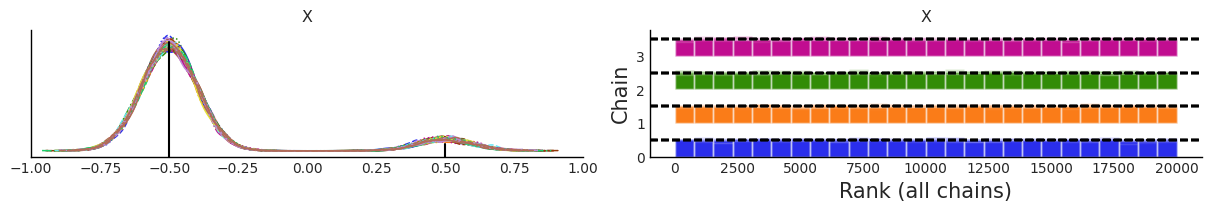

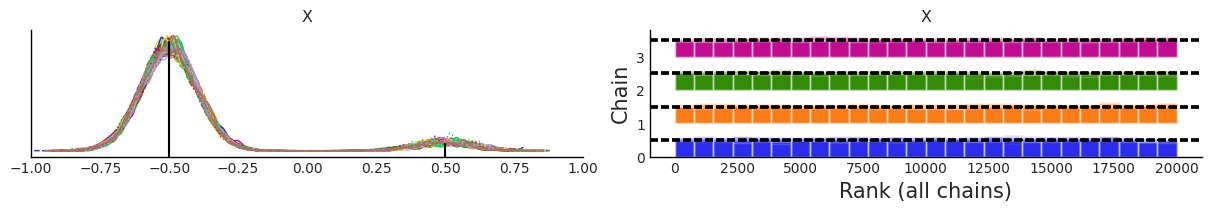

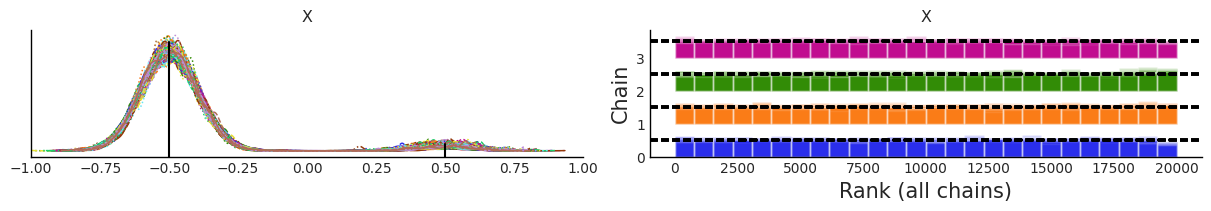

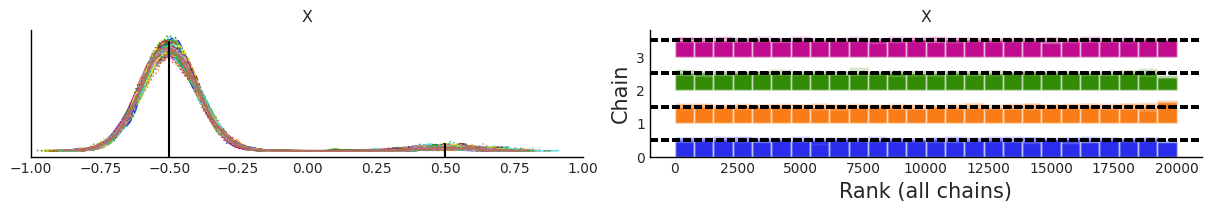

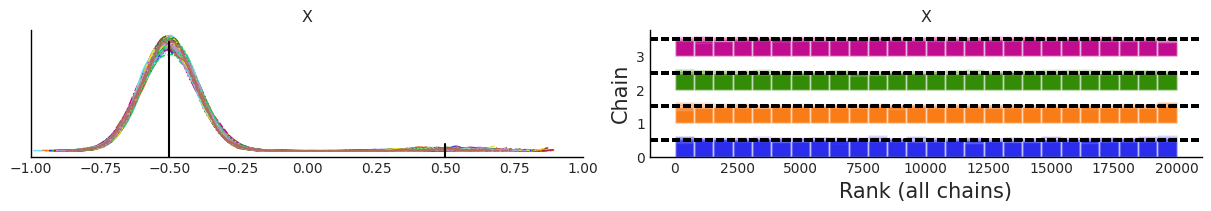

In [9]:
for n in dims:
    idata = idatas_gauss[str(n)]
    ax = az.plot_trace(idata, compact=True, kind="rank_bars")
    ax[0, 0].axvline(-0.5, 0, .9, color="k")
    ax[0, 0].axvline(0.5, 0, 0.1, color="k")
    ax[0, 0].set_xlim(-1, 1)
    print(np.mean(idata.posterior["X"] > 0).item())

In [10]:
for n in dims:
    cov_test = idatas_gauss[f'{n}'].sample_stats.cov
    print(f'{n}', np.shape(cov_test))# Errors in shapes

20 (4, 18, 20, 20)
40 (4, 26, 40, 40)
60 (1, 4)
80 (4, 38, 80, 80)
100 (4, 43, 100, 100)


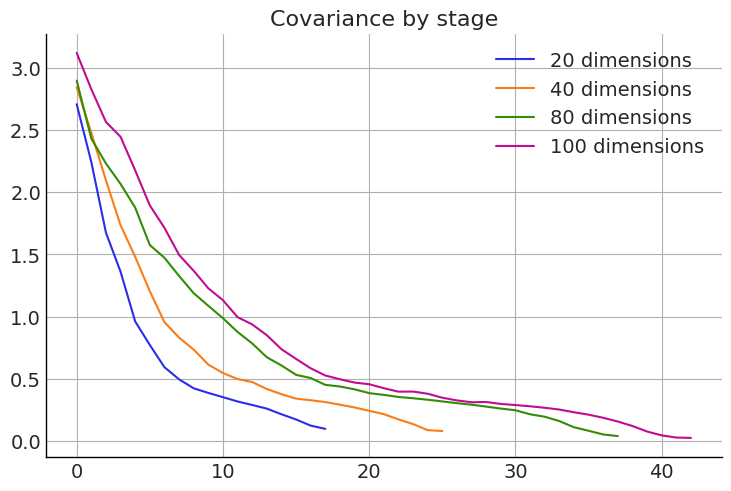

In [12]:
for n in ['20','40', '80', '100']:
    covariance_matrix = idatas_gauss[str(n)].sample_stats.cov
    beta_stages = np.shape(covariance_matrix)[1]
    x = [beta for beta in range(0,beta_stages)]
    y = [float(covariance_matrix[0][beta][0][0]) for beta in range(0,beta_stages)]
    plt.plot(x,y,label=f'{n} dimensions')
    plt.title("Covariance by stage")
    plt.legend()
    plt.grid(True)

# Compute error score  

For mixture of two D-dimensional Gaussians model, we evaluate the agreement between the SMC samples and the true posterior using the following error score:
  
  
\begin{equation}
 \sqrt{\frac{1}{N} \sum_n^N [(v_s-\mu_0) * w_0 +  (v_s-\mu_1) * w_1]^2} + \lvert (b - b^\prime) \rvert
\label{eq:rmsd_w_wang}
\end{equation}
  
  
The first term is the weighted root mean squared deviation (RMSD) computed from $N$ posterior draws, where $\mu_i$ and $w_i$ are the true mean and weight. The second term $b$ is the Wang bimodality index \cite{Wang2009} computed from the samples and $b^\prime$ is the true value. 

The Wang bimodality index characterizes the degree of bimodality of a distribution and is calculated as:

\begin{equation}
    b = \frac{\lvert \mu_0 - \mu_1 \rvert}{\sigma}\sqrt{w_0(1-w_0)}
\end{equation}

where $\mu_i$ are the means of each mode and $w_i$ is the relative weight of each Gaussian. For simplicity in this work we assume $\sigma=1$.

In [17]:
# Wang bimodality index True Value
for n in dims:
    mu1 = np.ones(n) * (1. / 2)
    mu2 = -mu1
    BI = abs(mu1 - mu2) * (w1*(1-w1))**0.5
    posterior = idatas_gauss[f'{n}'].posterior
    error_score_list = []

    for chain in posterior["chain"]:
        for dimension in posterior["X_dim_0"]:
            v = np.ravel(posterior.isel(chain=chain, X_dim_0=dimension)["X"])
            above_zero = v > 0
            below_zero = v < 0
            w1_ = np.mean(below_zero)
            if np.any(above_zero) and np.any(below_zero):
                BI_ = abs(v[below_zero].mean() - v[above_zero].mean()) * (w1_*(1-w1_))**0.5
            else:
                BI_ = 0
            error_score = (np.mean(((v-mu1[0]) * w1 + (v-mu2[0]) * w2)**2))**0.5 + abs(BI - BI_)
            error_score_list.append(error_score)

    print(np.mean(error_score_list), np.std(error_score_list))

0.3165405299126002 0.0004942355106420857
0.31910325938869444 0.001052584923156333
0.3279580847162256 0.003989872736630798
0.3405894430476531 0.006110405149195071
0.36374063358129227 0.006153326214631222


In [13]:
#Wasserstein distance

def cdf_bimodal_gauss(x):
    cdf1 = stats.norm(mu1[0], stdev).cdf(x)
    cdf2 = stats.norm(mu2[0], stdev).cdf(x)
    return w1 * cdf1 + w2 * cdf2


def wasserstein_distance(idata=idata, plot=True):
    """
    Compute wasserstein distance
    """
    
    # extract posterior, number of samples and dimensions
    x_posterior = idata.posterior["X"].stack(samples=("chain", "draw"))
    n_samples = x_posterior.samples.size
    dims = x_posterior.X_dim_0.size
    
    # evaluate (e)cdf at this points
    x = np.linspace(-1, 1, n_samples)

    # compute ecdf for each posterior marginal
    ecdf_obs = np.empty((n_samples, dims))
    for dim in x_posterior.coords["X_dim_0"]:
        values = np.sort(x_posterior.sel(X_dim_0=dim))
        ecdf_obs[:,dim] = np.searchsorted(values, x) / n_samples

    # compute the expected cdf
    ecdf_exp = cdf_bimodal_gauss(x)

    wsd = np.mean(np.mean((ecdf_obs.T - ecdf_exp)**2, axis=1)**0.5)
    
    if plot:
        _, ax = plt.subplots()
        ax.plot(x, ecdf_exp, "k", label="expected")
        ax.plot(x, ecdf_obs, "C1")
        ax.plot(0, 0, "C1",  label="observed")
        ax.legend()
        ax.set_title(f"Wasserstein distance ={wsd:.4f}")
    return wsd

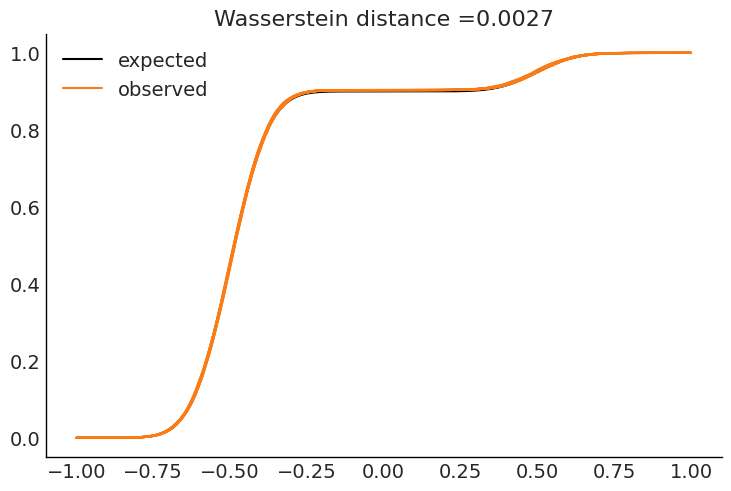

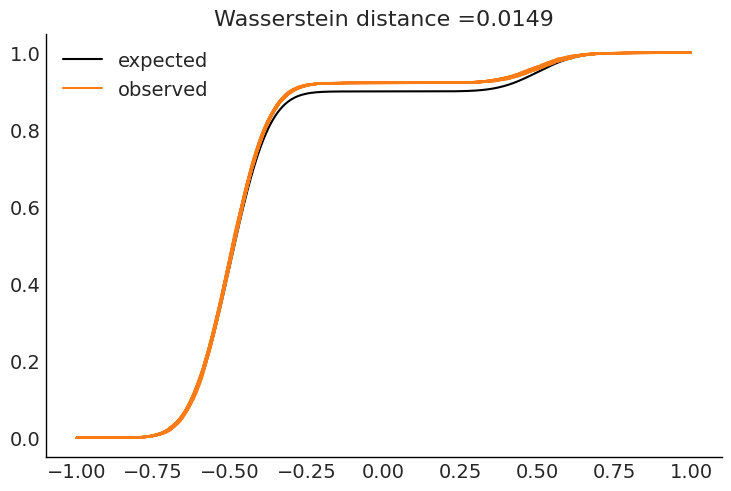

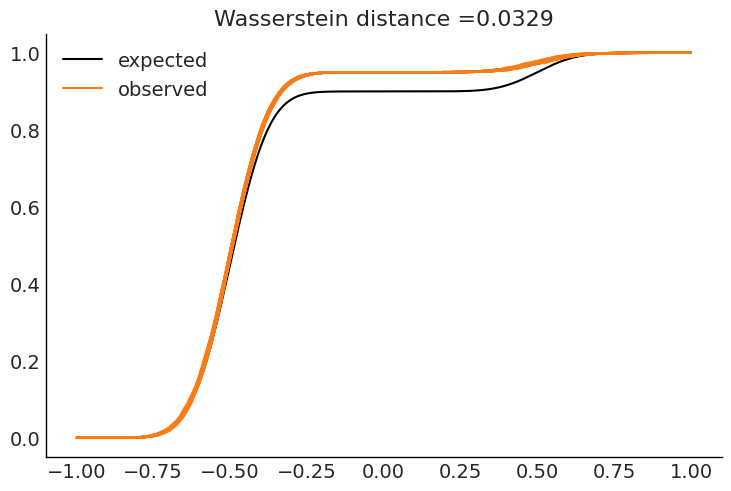

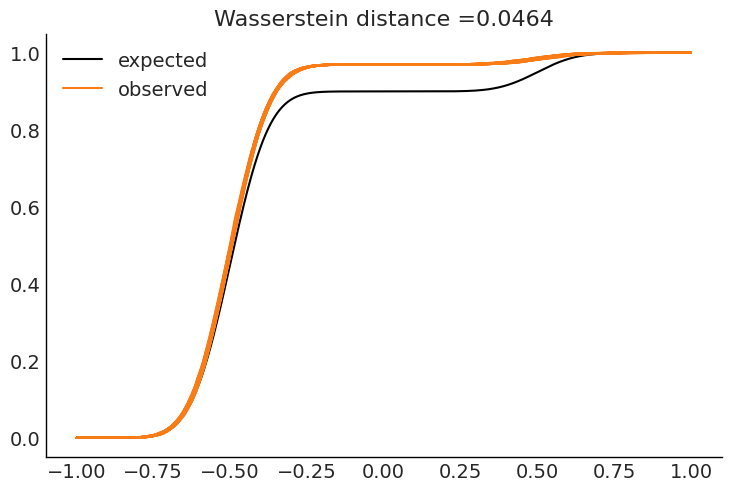

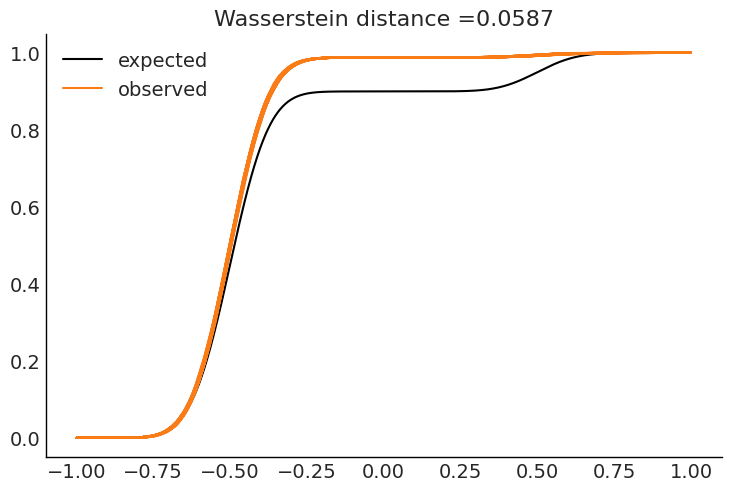

In [14]:
for n in dims:
    idata = idatas_gauss[str(n)]
    wasserstein_distance(idata)